# Exploratory Data Analysis

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
# from geopy.distance import distance

PATH = Path('data')


In [21]:
# will be used later to remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_feather(PATH/'houston_processed.feather')

In [6]:
df.shape
df.head(3).T

(353793, 21)

,0,1,2
accuracy,8,3,6
altitude,30,30,31
heading,161,307,320
velocity,0,0,0
verticalAccuracy,NaN,NaN,NaN
act_conf1,100,NaN,NaN
act_type1,STILL,None,None
act_cont2,NaN,NaN,NaN
act_type2,None,None,None
extra_intVal,NaN,NaN,NaN


## Generate date related features

In [ ]:
def generate_date_features(df):
    #convert timestampms (UTC time) to datetime US central (Texas time)
    df['date_time'] = pd.to_datetime(df.timestampMs,unit='ms').dt.tz_localize('utc').dt.tz_convert('US/Central')
    df['year']=df.date_time.dt.year

    df['month']=df.date_time.dt.month

    df['day']=df.date_time.dt.day

    df['day_of_week']=df.date_time.dt.dayofweek

    df['hour']=df.date_time.dt.hour
    df['minute'] = df.date_time.dt.minute
    
    df=df.drop('timestampMs',axis=1)
    
    return df

df = generate_date_features(df)
# fix lat - long
df['latitude'] = df.latitudeE7 / 1e7
df['longitude'] = df.longitudeE7 / 1e7

df.drop(['latitudeE7','longitudeE7'],axis=1,inplace=True)

# df.to_feather(PATH/'houston_processed.feather')

In [4]:
df.dtypes

accuracy                                 int64
altitude                               float64
heading                                float64
velocity                               float64
verticalAccuracy                       float64
act_conf1                              float64
act_type1                               object
act_cont2                              float64
act_type2                               object
extra_intVal                           float64
extra_name                              object
extra_type                              object
date_time           datetime64[ns, US/Central]
year                                     int64
month                                    int64
day                                      int64
day_of_week                              int64
hour                                     int64
minute                                   int64
latitude                               float64
longitude                              float64
dtype: object

In [5]:
df.groupby('year').size()

year
2013     10924
2015     25114
2016    288622
2017     29133
dtype: int64

There are few records from 2013 when I activated Google location history on my iphone, however 2014 records are missing

In [6]:
# remove year 2013 due to lack of records and to maintain the continuity of the dataset

idx_drop = df[df.year==2013].index

df.drop(idx_drop,inplace=True)

df.reset_index(drop=True,inplace=True)

In [7]:
df.groupby('year').size()

year
2015     25114
2016    288622
2017     29133
dtype: int64

# Distance differences (in miles) between 2 neighbor GPS points

In [10]:
def calculate_distance(lat1,long1,lat2,long2):
    # geopy default distance calculation is geodesic distance
    return float("{0:.2f}".format(distance((lat1,long1),(lat2,long2)).miles))

In [34]:
lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

In [35]:
from concurrent.futures import ProcessPoolExecutor
def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, *args)
    return (list(res))

In [36]:
args = [lat1,long1,lat2,long2]

In [37]:
%%time
mile_diff = multiprocessing(calculate_distance,args,4)

CPU times: user 2min 7s, sys: 21.8 s, total: 2min 29s
Wall time: 2min 34s


In [38]:
df['mile_diff'] = mile_diff

In [40]:
# df.to_feather(PATH/'houston_processed_miles_time_diff.feather')

Distance difference calculation can be faster if we manually code the distance formula

In [8]:
# faster way to calculate miles diff: manually calculate haversine distance, slightly difference from geodesic distance from geopy
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

km_diff = haversine_array(lat1,long1,lat2,long2) 
df['mile_diff'] = km_diff * 0.621371 # to miles

In [9]:
df.mile_diff.describe()

count    342869.000000
mean          0.066341
std           4.240514
min           0.000000
25%           0.000000
50%           0.000000
75%           0.005158
max        1382.520354
Name: mile_diff, dtype: float64

In [19]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

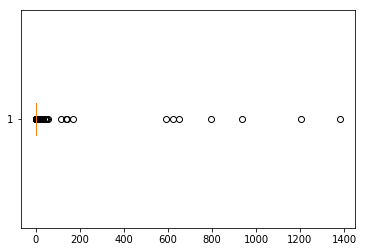

In [27]:
plt.boxplot(df.mile_diff,vert=False);

In [20]:
# remove outliers
df_no_outl = remove_outlier(df,'mile_diff')

In [26]:
# % of outliers for miles diff
(len(df) - len(df_no_outl)) / len(df)

0.1733985866322123

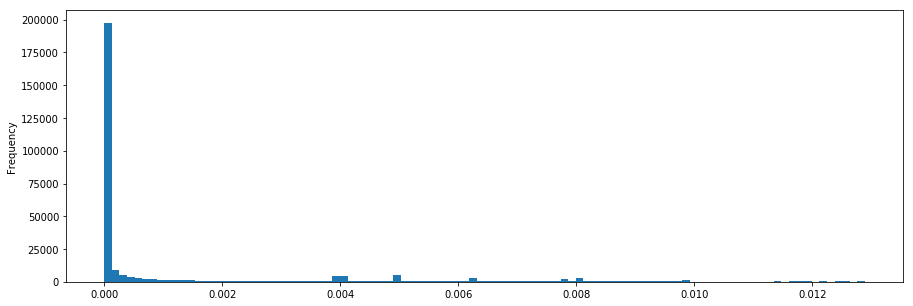

In [25]:
df_no_outl.mile_diff.plot(kind='hist',bins=100,figsize=(15,5));

In [20]:
# % of GPS points that are < 1 miles difference
len(df[df.mile_diff<1.0]) / len(df)

0.9911482227906285

99% of differences are less than 1 miles. I would say my android phone is consistent in recording GPS locations (no 2 points are too far from each other)

Verify some significant distance differences (> 10 miles)

In [30]:
df[df.mile_diff>10].groupby(['year','month','day']).mile_diff.mean()

year  month  day
2015  12     30      11.847001
2016  4      18      19.314191
      5      31     162.667397
      6      3      473.355821
      10     13     211.770165
      12     16      11.215220
             21      17.191957
             22     938.012779
             24     139.839309
             26      34.070700
             29      92.539037
2017  1      3      139.469908
Name: mile_diff, dtype: float64

All of these are out-of-state plane travel or out-of-city travel. This info could be helpful to identify far travel GPS points in my dataset

There are high differences in GPS points:
- GPS glitch?
- On plane: when on a plane (airplane mode, no gps recorded), every 100-200 seconds the phone will use the last available gps recorded location as current location. When airplane mode is off, it will record new gps location which results in a huge difference. 

# Time differences (in second) between 2 GPS points

In [32]:
date_shift = df.date_time.shift()
date_shift.loc[0] = df.date_time.loc[0]

In [33]:
df['sec_diff']=(df.date_time - date_shift).astype('timedelta64[s]')

In [34]:
df.sec_diff.describe()

count    342869.000000
mean        107.038435
std         229.959529
min           0.000000
25%          21.000000
50%          60.000000
75%         123.000000
max       46221.000000
Name: sec_diff, dtype: float64

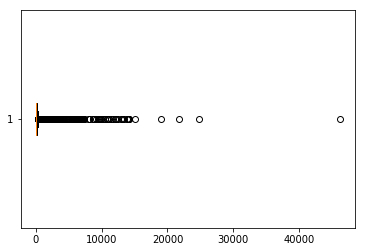

In [35]:
plt.boxplot(df.sec_diff,vert=False);

Remove outliers

In [37]:
df_no_outl = remove_outlier(df,'sec_diff')

In [38]:
# % of outliers for sec diff
(len(df) - len(df_no_outl)) / len(df)

0.14596828526346797

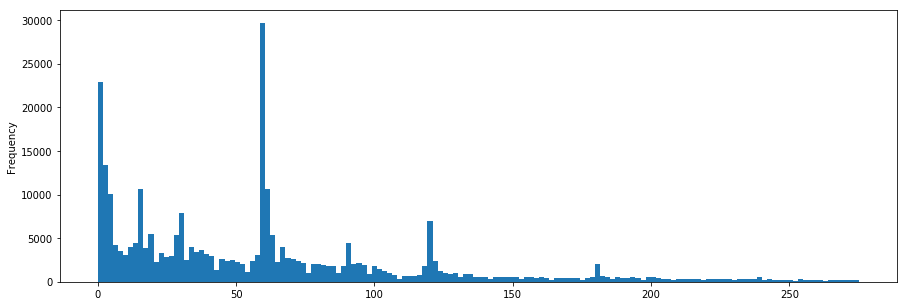

In [42]:
df_no_outl.sec_diff.plot(kind='hist',bins=150,figsize=(15,5))

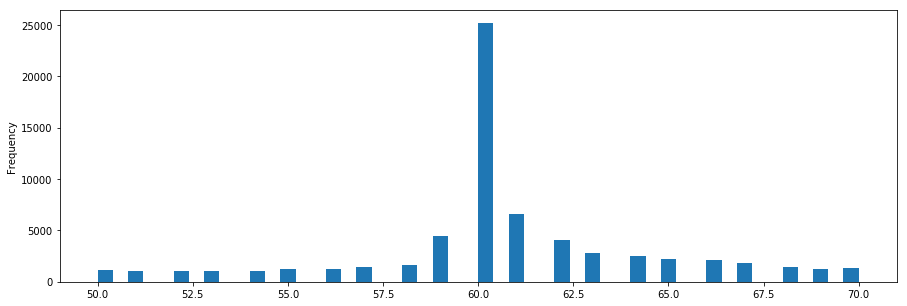

In [48]:
df_no_outl[(df_no_outl.sec_diff>=50) & (df_no_outl.sec_diff<=70)].sec_diff.plot(kind='hist',bins=50,figsize=(15,5))

It's safe to say that on average, Google timeline records my GPS points after every ~60 seconds and sometimes it records GPS points rapidly (less than 10 seconds)

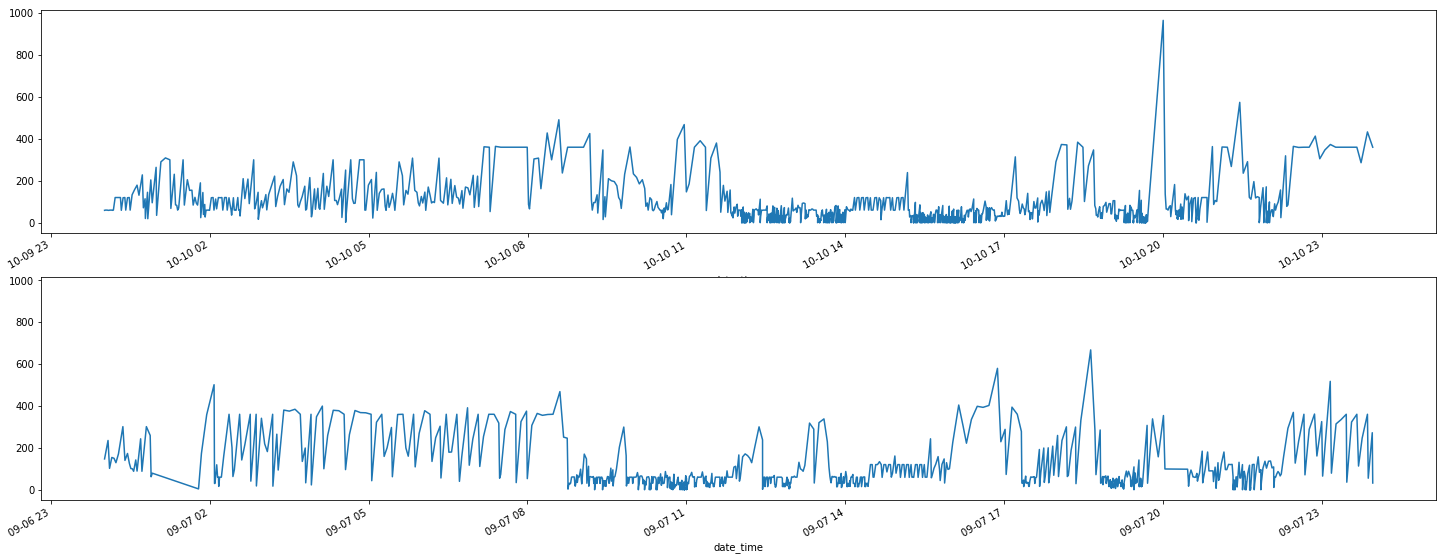

In [74]:
fig,axes= plt.subplots(nrows=2,figsize=(25,10),sharey=True)
norm_day = df[(df.year==2016) & (df.month==10)  & (df.day==10) & (df.sec_diff<1000)]
norm_day.set_index('date_time').sec_diff.plot(ax=axes[0]);

norm_day = df[(df.year==2016) & (df.month==9)  & (df.day==7) & (df.sec_diff<1000)]
norm_day.set_index('date_time').sec_diff.plot(ax=axes[1]);

Here are the time difference distribution for 2 typical school day (my common routine). We can see two patterns:
- Time difference is bigger (maximum is 200 to 400 seconds) during sleep time when there is little movement (before 9 am)
- Tim difference is smaller and more condense during school time when there is lot of movement between 9 am - 6 pm (commute, walk between classes) , and a mix between big and small during night time

# Calculate speed and identify abnormal speed

With both time differences and distance differences, we can easily calculate speed between 2 GPS points. From here we can identify odd GPS points if its speed is more than a threshold

In [2]:
# df = pd.read_feather(PATH/'houston_processed_miles_time_diff.feather')
# df.shape

(342869, 23)

In [90]:
# max speed
max_mph=80

In [91]:
speed = (df_timediff.mile_diff / df_timediff.sec_diff) * 3600 # miles/sec to mph

In [92]:
speed.describe()

count    322810.000000
mean          6.236048
std         117.219923
min           0.000000
25%           0.000000
50%           0.000000
75%           0.250316
max       38186.397830
dtype: float64

In [96]:
temp = df[df.sec_diff!=0] #exclude 0 time diff to avoid inf speed
df_abnormal=temp[speed>=max_mph]

In [97]:
df_abnormal.shape

(3857, 23)

Abnormal speed can be a result of GPS points glitch or plane travel. We will keep these GSP points

In [99]:
# keeping small glitches (<1 miles) or plane travel (probably > 15 miles)
abnormal_idx = df_abnormal[(df_abnormal.mile_diff>1) & (df_abnormal.mile_diff<15 )].index

In [100]:
abnormal_idx.shape

(1301,)

In [101]:
df.drop(abnormal_idx,inplace=True)

In [102]:
# at this point, mile diff and sec diff have to be recalculated. Remove them for now
df.drop(['mile_diff','sec_diff'],axis=1,inplace=True)

In [103]:
df.reset_index(drop=True,inplace=True)

In [104]:
df.shape

(341568, 21)

In [ ]:
df.to_feather(PATH/'houston_ready.feather')

# Quick GPS scatter plots

In [3]:
df = pd.read_feather(PATH/'houston_ready.feather')

(-98.5920927, -73.7636073)

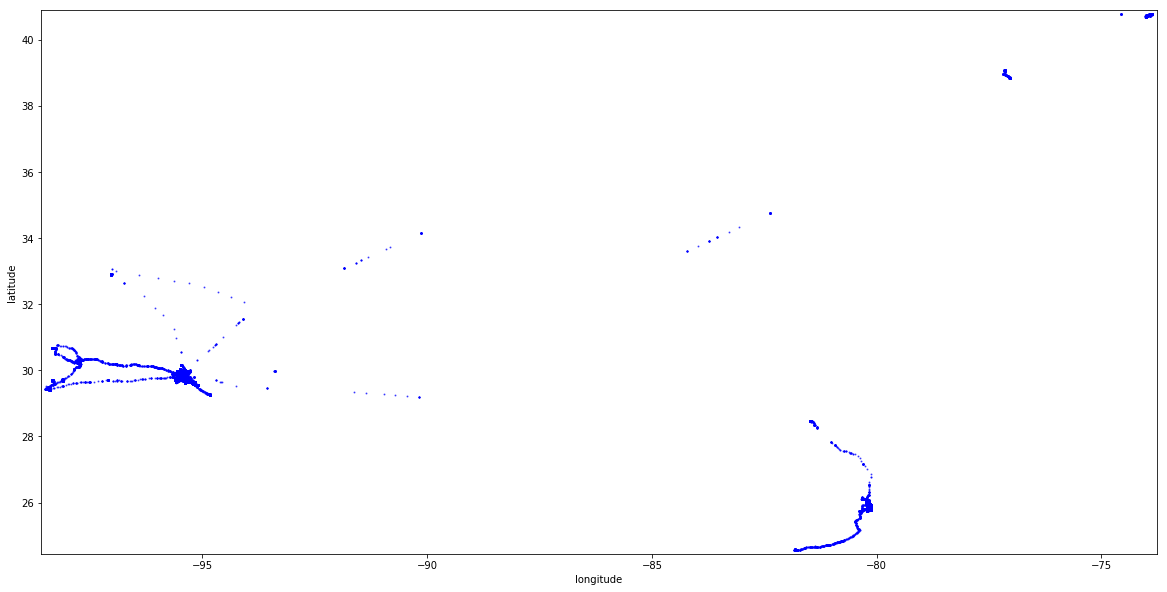

In [32]:
fig,ax = plt.subplots(figsize=(20,10))
ax.scatter(df.longitude,df.latitude,color='blue',s=1,alpha=0.6)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

Text(0.5,0,'longitude')

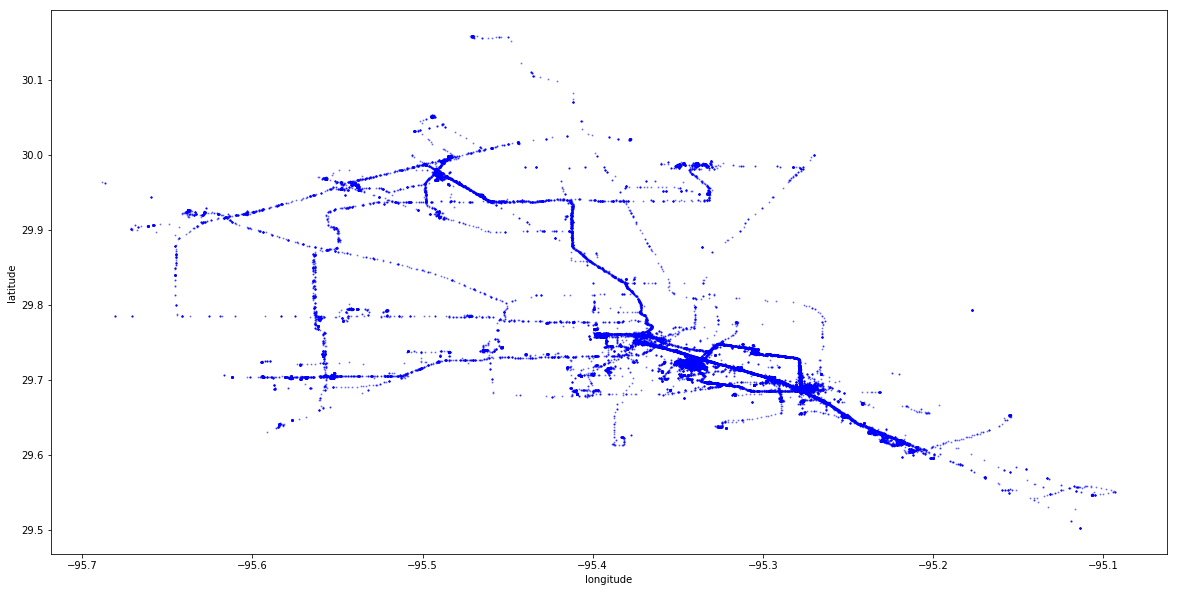

In [36]:
# analyzing Houston area
df_houston = df[(df.longitude <=-95) & (df.longitude >=-95.7)& (df.latitude >= 29.5) & (df.latitude <= 30.25)]

fig,ax = plt.subplots(figsize=(20,10))
ax.scatter(df_houston.longitude,df_houston.latitude,color='blue',s=1,alpha=0.4)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

Look pretty good. Houston road network is recognizable, and you can also see moving paths from both graphs(car and plane), some dense path and dense areas in Houston graph. We will look into it more in clustering notebook

# Single feature EDA

Dive deep into each features of this dataset

In [11]:
df = pd.read_feather(PATH/'houston_ready.feather')
df.shape

(341753, 21)

In [5]:
# % of missing values for each features
(df.isnull().sum() / len(df)) * 100

accuracy              0.000000
altitude             50.257935
heading              82.712954
velocity             98.336811
verticalAccuracy    100.000000
act_conf1            46.608808
act_type1            46.608808
act_cont2            73.497233
act_type2            73.497233
extra_intVal         99.985077
extra_name           99.985077
extra_type           99.985077
date_time             0.000000
year                  0.000000
month                 0.000000
day                   0.000000
day_of_week           0.000000
hour                  0.000000
minute                0.000000
latitude              0.000000
longitude             0.000000
dtype: float64

## Altitude

In [6]:
df.altitude.describe()

count    169995.000000
mean         -0.559893
std         321.730200
min       -9283.000000
25%         -24.000000
50%         -14.000000
75%           1.000000
max       11797.000000
Name: altitude, dtype: float64

In [106]:
df[df.altitude >= 2000].groupby(['year','month','day']).altitude.mean()

year  month  day
2016  5      31     9333.571429
      6      3      5822.000000
      8      16     3598.000000
      9      3      2393.000000
             6      2586.500000
      10     13     9874.796875
      11     19     2536.000000
      12     21     7045.347826
             29     8647.304348
Name: altitude, dtype: float64

Altitude can glitch as well. After checking with Google timeline site, some locations with high altitude are actually near home

In [107]:
df[df.altitude >= 5000].groupby(['year','month','day']).altitude.mean()
# about 5000 feet it seems to get all the airplane GPS point

year  month  day
2016  5      31      9333.571429
      6      3       5822.000000
      10     13     10066.048387
      12     21      8507.687500
             29     10505.562500
Name: altitude, dtype: float64

In [23]:
# def get_exact(df,year,month,day):
#     return df[(df.year == year) & (df.month == month) & (df.day==day)]
# get_exact(df[df.altitude < -400],2016,11,20)

In [108]:
lowest=-400
df[df.altitude < lowest].groupby(['year','month','day']).altitude.mean()


year  month  day
2016  1      15     -639.000000
             28     -465.000000
      2      5      -623.750000
             9      -435.000000
             20     -566.000000
             24     -403.000000
      3      4      -449.000000
             14     -591.000000
             20     -541.000000
      4      2      -787.000000
             19     -545.000000
             28     -564.000000
      6      1     -1126.500000
             28     -575.000000
      7      17     -753.200000
             27     -421.000000
      8      1      -411.000000
             3      -425.000000
             6      -702.000000
             16     -850.400000
             17    -1043.000000
             18     -580.000000
             25     -968.416667
             26    -1140.444444
             28     -584.000000
      9      2      -682.750000
             3      -762.356322
             4     -1033.111111
             5      -762.100000
             6     -1437.670886
             30     -41

In [109]:
df[df.altitude < lowest].shape

(708, 21)

After checking with Google Timeline site, majority of these 'low' altitudes are glitch. Majority of them are at home

We will remove these low altitude. We still keep high altitude as it can help to identify flight path

In [12]:
# remove low altitude. Keep high altitude as it can be plane travel
df[(df.altitude >=-400) | (df.altitude.isnull())].shape
df.shape

(341045, 21)

(341753, 21)

In [13]:
df = df[(df.altitude >=-400) | (df.altitude.isnull())]

In [14]:
df.shape

(341045, 21)

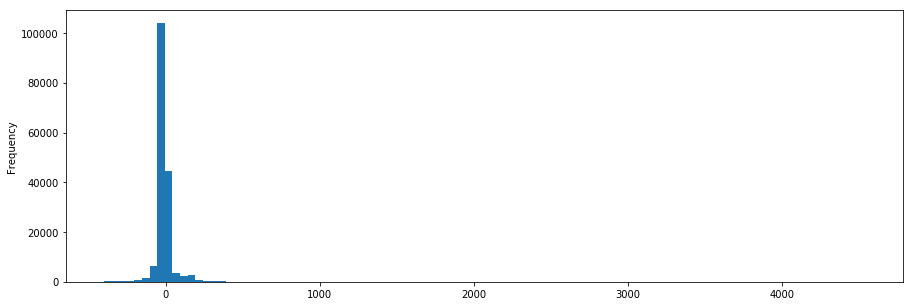

In [78]:
# view ground (normal) altitude
df[df.altitude < 5000].altitude.plot(kind='hist',bins=100,figsize=(15,5))

## Deal with missing values

Half of dataset is missing Altitude values. 

Altitude cannot be changed easily, so we will use pandas forward fill to deal with missing values

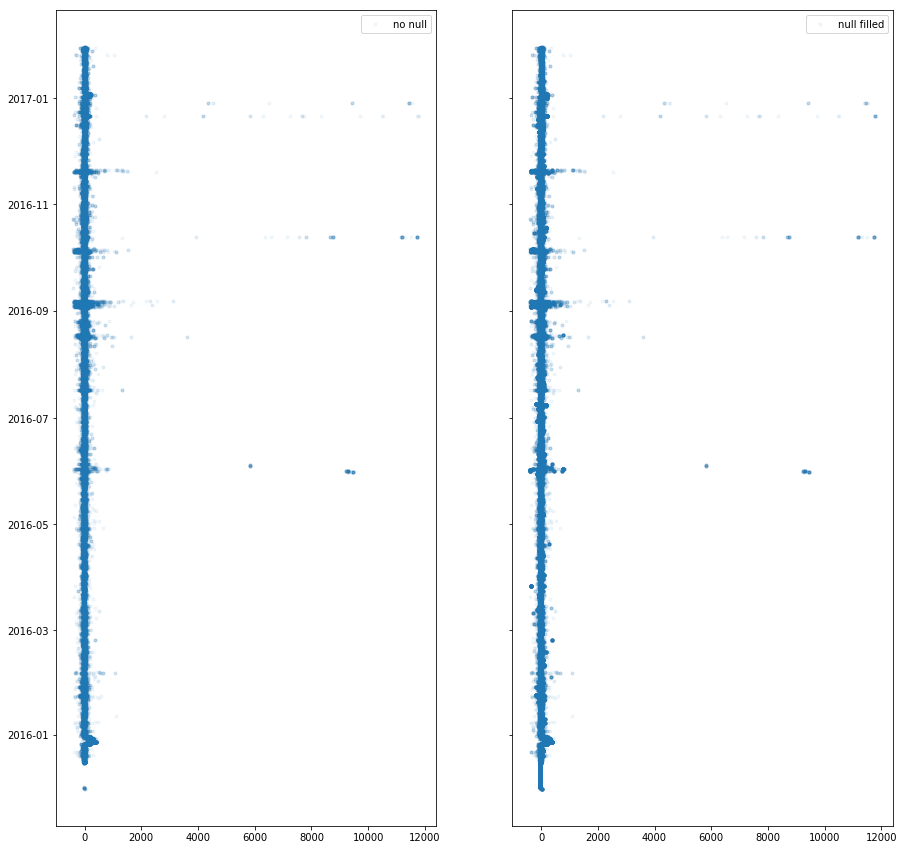

In [100]:
# Altitude cannot be changed easily, so use forward fill
alt = df.altitude
alt_fillna = df.altitude.fillna(method='ffill')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,15),sharex=True,sharey=True)
ax[0].plot(alt,df.date_time,'.',alpha=0.05,label='no null')
ax[1].plot(alt_fillna,df.date_time,'.',alpha=0.05,label='null filled')

ax[0].legend(loc=0)
ax[1].legend(loc=0)

In the left graph (null data isn't plotted), there aren't many gaps in altitude even though altitude contains 50% missing values, and it seems to stay stable (there is no big altitude jump resulting in zic-zac pattern). Forward filling is not a bad first choice

In [15]:
df.altitude.fillna(method='ffill',inplace=True)

In [18]:
df.altitude.fillna(0,inplace=True) # use 0 for first few NaN altitudes

## Heading

In [79]:
df.heading.describe()
# 0-360 degree?

count    58748.000000
mean       186.498025
std        101.580146
min          0.000000
25%        106.000000
50%        180.000000
75%        277.000000
max        359.000000
Name: heading, dtype: float64

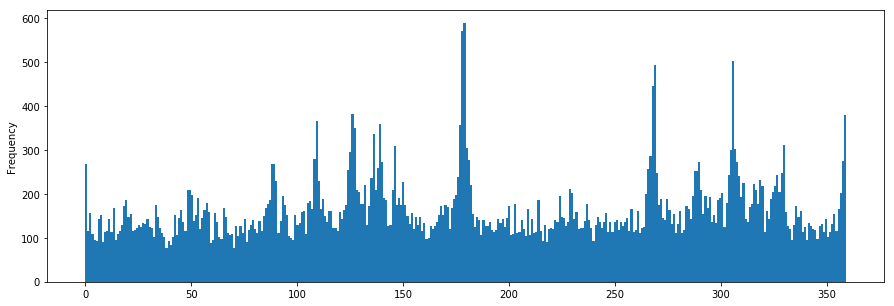

In [108]:
df.heading.plot(kind='hist',bins=360,figsize=(15,5))

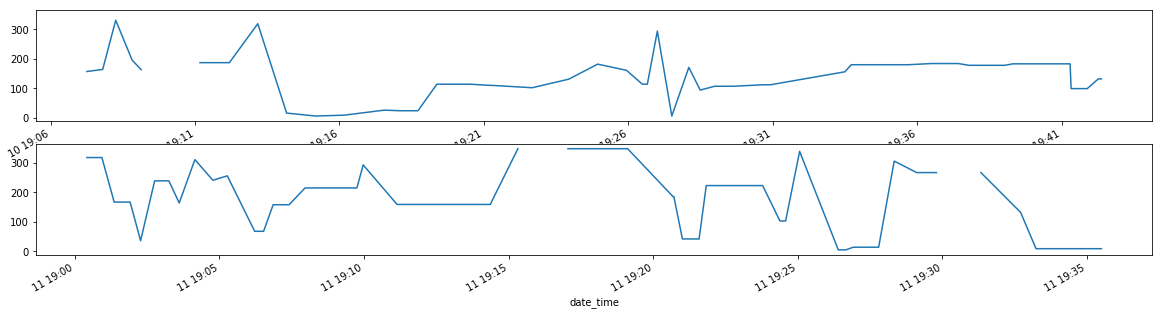

In [112]:
fig,axes= plt.subplots(nrows=2,figsize=(20,5),sharey=True)

# typical routine
norm_day = df[(df.year==2016) & (df.month==10)  & (df.day==10) & (df.hour >= 19) & (df.hour <21)]
norm_day.set_index('date_time').heading.plot(ax=axes[0]);

# same routine, a date later 
norm_day = df[(df.year==2016) & (df.month==10)  & (df.day==11) & (df.hour >= 19) & (df.hour <21)]
norm_day.set_index('date_time').heading.plot(ax=axes[1]);

Unfortunately, they did not share the same pattern

Let's see if heading is anywhere related to activity type

In [164]:
df_temp = df[~df.heading.isnull()]
df_temp.act_type1.value_counts() / len(df_temp)

IN_VEHICLE         0.285865
TILTING            0.284605
STILL              0.092088
UNKNOWN            0.044444
ON_FOOT            0.012579
EXITING_VEHICLE    0.010996
ON_BICYCLE         0.002826
Name: act_type1, dtype: float64

A record with heading has higher chance to have type 'IN_VEHICLE' or 'TILTING'

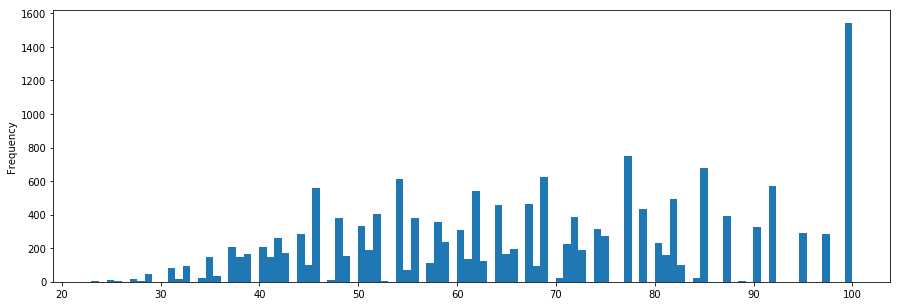

In [165]:
df_temp[df_temp.act_type1=='IN_VEHICLE'].act_conf1.plot(kind='hist',bins=100,figsize=(15,5))

In [166]:
len(df_temp[(df_temp.act_type1=='IN_VEHICLE') & (df_temp.act_conf1 >=80)]) / len(df_temp[df_temp.act_type1=='IN_VEHICLE'])

0.30350125044658804

For records with heading, only ~30% of them have IN_VEHICLE confidence >=80, meaning having heading does not always mean user is in a vehicle

Heading would be a bad feature to be considered because:
- 82% missing values
- Not stable (different pattern for 2 similar records)
- Not sure how heading is generated. My best bet: heading is related to vehicle heading, but only 30% of records with heading have high IN_VEHICLE confidence

We can extract these heading records to study them later.

## Velocity

98% missing values

In [36]:
df.velocity.isnull().sum() / len(df)

0.9833541028310047

In [19]:
df.velocity.describe()

count    5677.000000
mean        2.370442
std         5.877268
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        34.000000
Name: velocity, dtype: float64

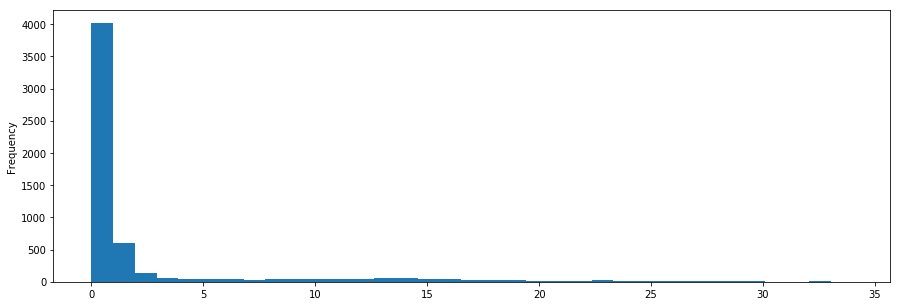

In [23]:
df.velocity.plot(kind='hist',bins=35,figsize=(15,5))

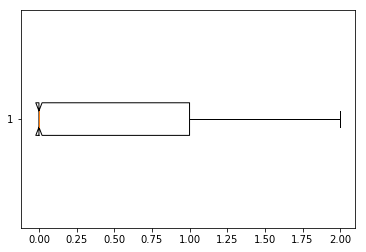

In [31]:
plt.boxplot(df[~df.velocity.isnull()].velocity,1,'',vert=False);
# no outlier plots

This is another bad feature. For a 'velocity' feature, majority are between 0 and 1. Not sure if this is mph or kph; either way, it would be too low.

## Activity type and activity confidence

Based on data cleaning, first activity type (act_type1) has the highest confidence.


In [37]:
df.act_type1.isnull().sum() / len(df)

0.46627864358075916

There are 46% missing values

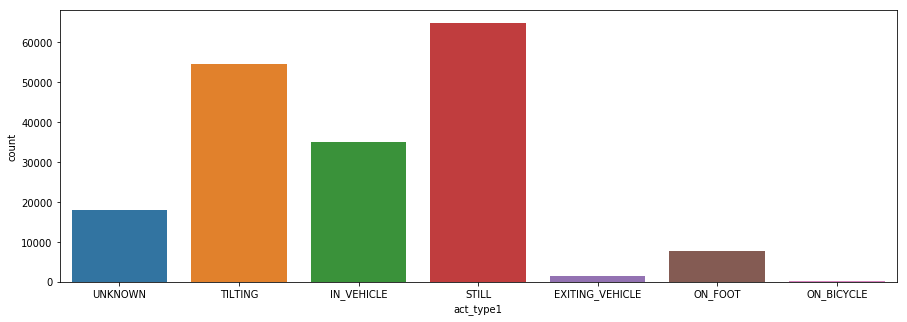

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(ax=ax,x=df.act_type1,data=df)

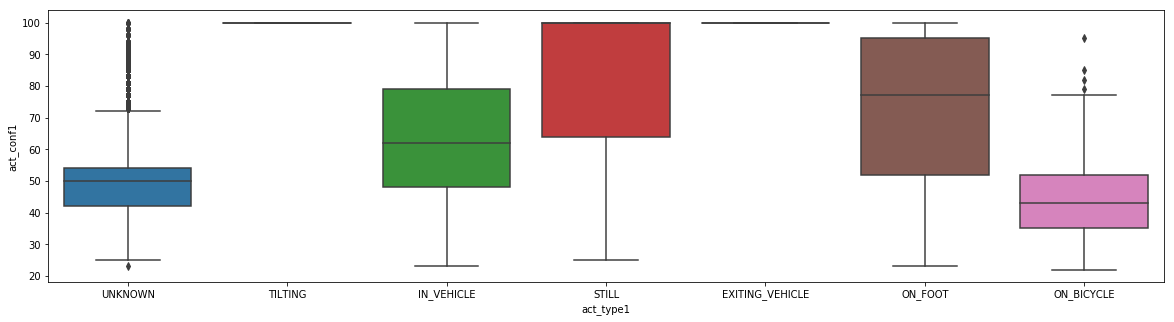

In [34]:
fig,ax = plt.subplots(figsize=(20,5))
sns.boxplot(ax=ax,x='act_type1',y='act_conf1',data=df)

'TILTING' is the most confident activity Google comes up with. However, after checking with google timeline, TILTING can relate to home GPS location (still), school location and even on driving path.

Let's check to see whether 'IN_VEHICLE' is accurate label by checking how many high confidence IN_VEHICLE data points are in 'home' square area; between (29.6890,-95.2719) and (29.6899, -95.2708). A point to be considered 'high confidence' will have act_conf1 >= 70

In [67]:
temp = df[(df.act_type1 == 'IN_VEHICLE') & (df.act_conf1 >=70) & (df.latitude>=29.6890) & (df.latitude <=29.6899) & (df.longitude>=-95.2719) & (df.longitude <=-95.2708)]
temp.head().T

,374,558,560,561,573
accuracy,30,30,30,30,30
altitude,-25,-25,-25,-25,-25
heading,NaN,NaN,NaN,NaN,NaN
velocity,NaN,NaN,NaN,NaN,NaN
verticalAccuracy,NaN,NaN,NaN,NaN,NaN
act_conf1,85,71,92,92,87
act_type1,IN_VEHICLE,IN_VEHICLE,IN_VEHICLE,IN_VEHICLE,IN_VEHICLE
act_cont2,8,19,8,8,5
act_type2,ON_BICYCLE,UNKNOWN,ON_FOOT,UNKNOWN,ON_BICYCLE
extra_intVal,NaN,NaN,NaN,NaN,NaN


In [65]:
len(temp) / len(df[(df.act_type1 == 'IN_VEHICLE') & (df.act_conf1 >=70)])

0.25301778907242695

25% high-confidence 'IN_VEHICLE' records are actually at home (where it should be STILL or ON_FOOT). It could be higher if I check with other still places such as work.

I might need to look into it more, but it is safe to say that Activity is not a reliable record.

# 'Extra' features

As discussed in cleaning_long.ipynb notebook, Extra features for this dataset only contain 1 value:
```
'extra': [{'type': 'VALUE', 'name': 'vehicle_personal_confidence', 'intVal': 100}]
```

Also these features are 99.9% missing. It's safe to disregard 'extra'

In [69]:
df.reset_index(drop=True,inplace=True)
df.to_feather(PATH/'houston_ready.feather')